<a href="https://colab.research.google.com/github/mar-ale-fer/dio-ml-bootcamp/blob/main/combine_detection_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Required Libraries
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, load_model
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import img_to_array

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow


# Set TensorFlow logging level to ERROR to suppress unnecessary logs
tf.get_logger().setLevel('ERROR')

In [3]:
from google.colab import drive
import shutil
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# create folder to copy weights from drive
destination_path = '/content/weights'
os.makedirs(destination_path, exist_ok=True)

In [5]:
# copy trained model generated in other colab notebook:

drive_path_to_model= '/content/drive/MyDrive/gaby_bauty_other_vgg_weights/vgg.trained_model.weights.h5'
local_path_to_model= '/content/weights/vgg.trained_model.weights.h5'

!cp "{drive_path_to_model}" "{local_path_to_model}"



In [63]:

# Load Pre-Trained VGG16 Model

# Work-around:I changed include_top to True to adapt to my model... and avoid to retrain the weights
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

#x = tf.keras.layers.Flatten()(base_model.output)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dense(3, activation='softmax')(x)  # 3 classes: Gaby, Bauty, Other

x = base_model.layers[-2].output  # Reference the second-to-last layer

# Add your new classification layer
x = Dense(3, activation='softmax')(x)  # 3 classes: Gaby, Bauty, Other

model = Model(inputs=base_model.input, outputs=x)
model.load_weights(local_path_to_model)  # Load your trained weights


In [64]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [65]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [66]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


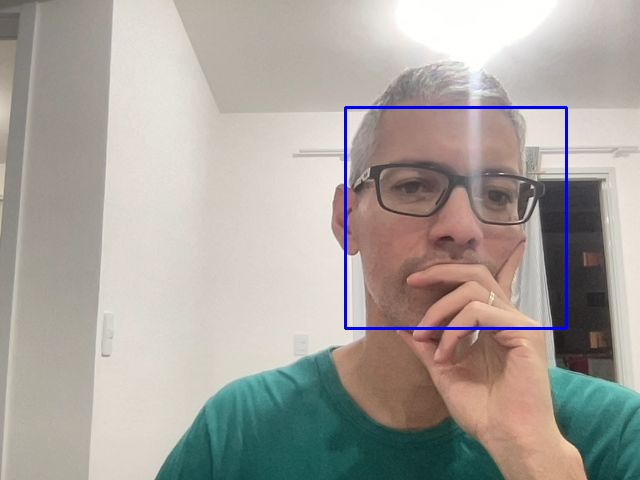

In [67]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [69]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [78]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialize bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get face region coordinates
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    label_html = "No Faces Detected"

    # Process each detected face
    for (x, y, w, h) in faces:
        # Draw bounding box
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract and preprocess the face
        face_array = preprocess_face(img, x, y, w, h)

        # Reverse preprocessing to show the face image
        face_display = unprocess_face(face_array)

        # Resize face_display to match the height of the original image
        height, width = img.shape[:2]
        face_resized_for_display = cv2.resize(face_display, (int(width * (height / 224)), height))  # Resize the face


        # Display the original image and the processed face side by side
        combined = np.hstack((img, face_resized_for_display))  # Combine the webcam feed and face image horizontally
        #---> activate it for debug cv2_imshow(combined)  # Display the combined image
        # Perform prediction
        predicted_class, confidence = predict_face(face_array)
        # if confidence is < 80, it's other
        if confidence < 0.8:
          label_html = f"Class: Other"
        else:
          # Map predicted class to a label
          class_mapping = {0: "Gaby", 1: "Bauty", 2: "Other"}
          label_html = f"Class: {class_mapping[predicted_class]}, Confidence: {confidence:.2f}"

    # Convert overlay of bbox into bytes
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox and label for the next frame
    bbox = bbox_bytes



<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [31]:
# Initialize OpenCV's Haar Cascade for face detection
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

def preprocess_face(frame, x, y, w, h):
    """
    Crop, resize, and preprocess a face image for the model.
    """
    face = frame[y:y + h, x:x + w]
    face_resized = cv2.resize(face, (224, 224))  # Resize to model input size
    face_array = img_to_array(face_resized)
    face_array = np.expand_dims(face_array, axis=0)
    return preprocess_input(face_array)



In [42]:
def unprocess_face(face_array):
    """
    Reverse preprocessing (such as normalization) to display the face image.
    """
    # Unnormalize (you may adjust this if you applied any custom normalization)
    face_array = face_array.squeeze()
    face_array += 103.939  # Reverse normalization for VGG16
    face_array = cv2.cvtColor(face_array, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    return face_array

In [74]:
def predict_face(face_array):
    """
    Predict the class and confidence of the processed face using the model.
    """
    predictions = model.predict(face_array, verbose= 0)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)
    return predicted_class, confidence


In [9]:

def draw_annotations(frame, x, y, w, h, label):
    """
    Draw bounding box and label on the frame.
    """
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
